# (1) 데이터 불러오기

In [51]:
!mkdir -p ~/work/data_augmentation/data
# !pip install --upgrade pip
# !pip install --upgrade torch torchvision

In [52]:
# PyTorch and torchvision
import torch
import torchvision

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print('=3')

=3


In [53]:
# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [54]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -P ~/work/data_augmentation/data
!tar -xf ~/work/data_augmentation/data/images.tar -C ~/work/data_augmentation/data/

--2026-01-26 01:31:38--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘/home/jovyan/work/data_augmentation/data/images.tar.3’

images.tar.3        100%[===================>] 756.82M  8.98MB/s    in 1m 45s  

2026-01-26 01:33:23 (7.20 MB/s) - ‘/home/jovyan/work/data_augmentation/data/images.tar.3’ saved [793579520/793579520]



In [76]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

dataset_dir = "~/work/data_augmentation/data/Images/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
])
full_dataset = ImageFolder(root=dataset_dir, transform=transform)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # 약 12,000개
test_size = total_size - train_size   # 약 8,580개
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=32, shuffle=False)
ds_info = {
    "num_classes": len(full_dataset.classes),
    "class_names": full_dataset.classes
}

print("=3")

=3


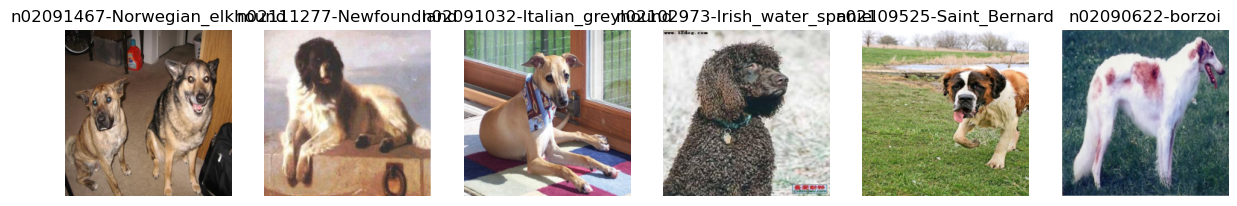

In [77]:
# DataLoader에서 일부 배치 가져오기
def show_examples(data_loader, class_names, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
        image = (image * 0.5) + 0.5
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_names[labels[i].item()])

    plt.show()

# 훈련 데이터 샘플 시각화
show_examples(train_loader, ds_info["class_names"])

# (2) Augmentation 적용하기

In [57]:
'''
# 랜덤 확률로 바로 적용할 수 있는 augmentation 함수

transforms.ColorJitter()
transforms.RandomResizedCrop()
transforms.RandomHorizontalFlip()
transforms.RandomVerticalFlip()
transforms.RandomAdjustSharpness()
'''

'\n# 랜덤 확률로 바로 적용할 수 있는 augmentation 함수\n\ntransforms.ColorJitter()\ntransforms.RandomResizedCrop()\ntransforms.RandomHorizontalFlip()\ntransforms.RandomVerticalFlip()\ntransforms.RandomAdjustSharpness()\n'

In [78]:
#이미지 변환 전처리 함수
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 통일
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
    ])

In [79]:
def augment():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2)
    ])

print('=3')

=3


In [80]:
# 데이터셋을 가공하는 메인함수
# with_aug: aug. 적용여부

def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):
    transform = normalize_and_resize_img()

    if not is_test and with_aug:
        dataset.dataset.transform = transforms.Compose([
            *augment().transforms,
            *transform.transforms
        ])
    else:
        dataset.dataset.transform = transform

    return DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

print('=3')

=3


In [81]:
import random

#다양한 augmentation 기법을 랜덤하게 적용하는 함수

def augment2():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.5),    # 상하 반전
        transforms.RandomRotation(degrees=(0, 90, 180, 270)),  # 90도 단위 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 밝기, 대비, 색상 조정
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 랜덤 크롭 후 리사이즈
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 0~1 값으로 클리핑
    ])

print('=3')

=3


In [82]:
import torch.nn as nn
import torchvision.models as models

num_classes = len(ds_info["class_names"])
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# model = nn.Sequential(
#     resnet50,
#     nn.AdaptiveAvgPool2d((1, 1)),
#     nn.Flatten(),
#     nn.Linear(resnet50.fc.in_features, num_classes),
#     nn.Softmax(dim=1)
# )

print("=3")


=3


In [83]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet

aug_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
aug_resnet50.fc = nn.Linear(aug_resnet50.fc.in_features, num_classes)

#aug_resnet50 = nn.Sequential(
#    aug_resnet50,
#    nn.Softmax(dim=1)
#)

print("=3")

=3


In [84]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

print("=3")

=3


In [85]:
%%time
import torch.optim as optim

EPOCH = 10  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001)

def train(model, train_loader, test_loader, epochs):
    model.to(device)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history

CPU times: user 826 μs, sys: 0 ns, total: 826 μs
Wall time: 837 μs


In [ ]:
history_resnet50_no_aug = train(resnet50, ds_train_no_aug, ds_test, EPOCH)

In [86]:
%%time
history_resnet50_aug = train(aug_resnet50, ds_train_aug, ds_test, EPOCH)

Epoch [1/10], Accuracy: 0.88%
Validation Accuracy: 0.84%
Epoch [2/10], Accuracy: 0.87%
Validation Accuracy: 0.89%
Epoch [3/10], Accuracy: 0.76%
Validation Accuracy: 0.91%
Epoch [4/10], Accuracy: 0.81%
Validation Accuracy: 0.87%
Epoch [5/10], Accuracy: 0.80%
Validation Accuracy: 0.85%
Epoch [6/10], Accuracy: 0.75%
Validation Accuracy: 0.86%
Epoch [7/10], Accuracy: 0.83%
Validation Accuracy: 0.84%
Epoch [8/10], Accuracy: 0.75%
Validation Accuracy: 0.86%
Epoch [9/10], Accuracy: 0.83%
Validation Accuracy: 0.83%
Epoch [10/10], Accuracy: 0.84%
Validation Accuracy: 0.84%
CPU times: user 26min 1s, sys: 39.6 s, total: 26min 41s
Wall time: 25min 40s


**Q. 노드 코드인데, 왜 학습이 잘 안되는 걸까요 ..??**

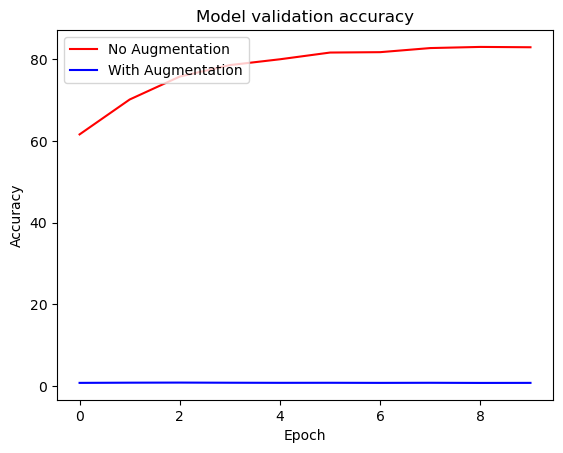

In [87]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

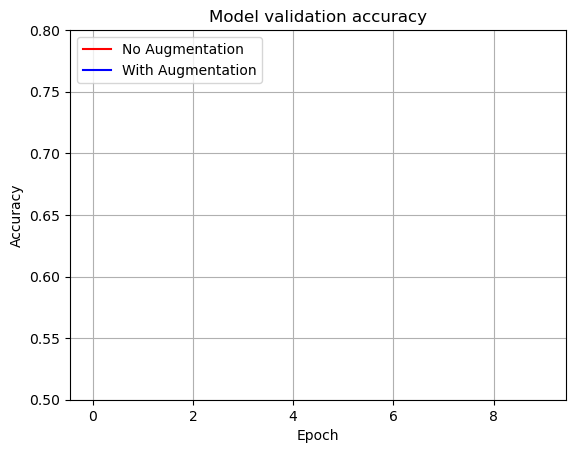

In [88]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

## Cutmix Augmentation

### 미리보기

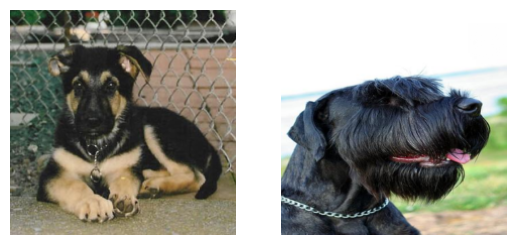

In [89]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다.
data_iter = iter(ds_train_no_aug)
images, labels = next(data_iter)

# 첫 번째 배치에서 두 개의 이미지 선택
image_a = images[0].permute(1, 2, 0).numpy()
image_b = images[1].permute(1, 2, 0).numpy()
label_a = labels[0].item()
label_b = labels[1].item()

# 정규화된 텐서를 다시 [0, 1] 범위로 조정
image_a = (image_a * 0.5) + 0.5
image_b = (image_b * 0.5) + 0.5

# 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(image_a)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_b)
plt.axis('off')

plt.show()

### 함수 정의하기

In [90]:
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x :', x_min, x_max)
print('y :', y_min, y_max)

x : 0 3
y : 92 224


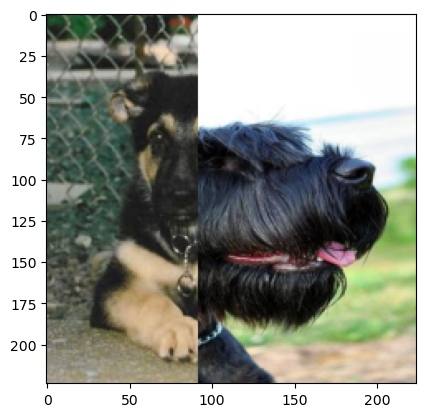

In [91]:
import torch

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    if isinstance(image_a, np.ndarray):
        image_a = torch.from_numpy(image_a).to(device)
    if isinstance(image_b, np.ndarray):
        image_b = torch.from_numpy(image_b).to(device)

    top = image_a[:, :y_min, :]
    middle_left = image_a[:, y_min:y_max, :x_min]
    middle_center = image_b[:, y_min:y_max, x_min:x_max]
    middle_right = image_a[:, y_min:y_max, x_max:]
    bottom = image_a[:, y_max:, :]

    top = top.to(device)
    middle_left = middle_left.to(device)
    middle_center = middle_center.to(device)
    middle_right = middle_right.to(device)
    bottom = bottom.to(device)

    # 중간 부분(왼쪽, 중앙, 오른쪽) 결합
    middle = torch.cat([middle_left, middle_center, middle_right], dim=2)

    # 전체 이미지 결합 (위 + 중간 + 아래)
    mixed_img = torch.cat([top, middle, bottom], dim=1)

    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.cpu().numpy())
plt.show()

In [92]:
import torch.nn.functional as F

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # 바운딩 박스 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

     # 원-핫 벡터 변환
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 비율에 따라 라벨 혼합
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

# 예제 실행
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
print(mixed_label)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.5893, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.4107, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [93]:
def cutmix(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        j = torch.randint(0, batch_size, (1,)).item()  # 다른 샘플 선택
        image_b = images[j]
        label_b = labels[j]

        # 바운딩 박스 생성
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    # 텐서 변환
    mixed_imgs = torch.stack(mixed_imgs).reshape(batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).reshape(batch_size, num_classes)

    return mixed_imgs, mixed_labels

print("=3")

=3


In [ ]:
%%time
import torch.optim as optim

EPOCH = 10  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001)

def train_cutmix(model, train_loader, test_loader, epochs, use_cutmix=False):
    model.to(device)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 원핫인코딩
            labels = F.one_hot(
                labels, num_classes=ds_info["num_classes"]
            ).float()

            if use_cutmix:
                images, labels = cutmix(
                    images,
                    labels,
                    batch_size=images.size(0),
                    img_size=224,
                    num_classes=ds_info["num_classes"]
                )

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            hard_labels = labels.argmax(dim=1)
            total += hard_labels.size(0)
            correct += predicted.eq(hard_labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {100.*correct/total:.2f}%")

        # validation (CutMix X)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history


In [ ]:
history_resnet50_cutmix = train_cutmix(resnet50, train_loader, test_loader, EPOCH, use_cutmix=True)

Epoch [1/10], Train Acc: 1.05%
Validation Accuracy: 0.55%


In [ ]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g', label='With CutMix')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Mixup Augmentation

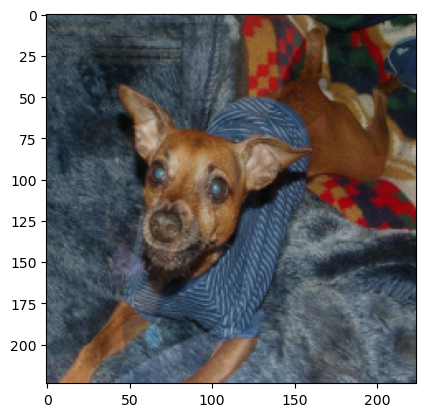

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2511, 0.0000, 0.0000, 0.7489, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [23]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()  # 0~1 사이의 랜덤 값

    # 라벨 원핫 인코딩
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

# 예제 실행
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img)
plt.show()

print(mixed_label)

In [24]:
def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, batch_size, (1,)).item()
        image_b = images[j]
        label_b = labels[j]

        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs).view(batch_size, 3, img_size, img_size)  # (B, C, H, W)
    mixed_labels = torch.stack(mixed_labels).view(batch_size, num_classes)  # (B, num_classes)

    return mixed_imgs, mixed_labels

print('=3')

=3


In [ ]:
def train_mixup(model, train_loader, test_loader, epochs, use_mixup=False):
    model.to(device)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Mixup
            if use_mixup:
                images, labels = mixup(
                    images,
                    labels,
                    batch_size=images.size(0),
                    img_size=224,
                    num_classes=120
                )

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # accuracy는 hard label 기준
            _, predicted = outputs.max(1)
            hard_labels = labels.argmax(dim=1)
            total += hard_labels.size(0)
            correct += predicted.eq(hard_labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        # validation (mixup X)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history


In [ ]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g', label='With CutMix')
plt.plot(history_resnet50_mixup['val_accuracy'], 'o', label='With Mixup')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 비교분석

1. 기본 Augmentation

2. MixUp

3. CutMix

성능 비교 분석

MixUp + ResNet50

CutMix + ResNet50